## Image classification with Convolutional Neural Networks


In [15]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
# This following code is to makesure I have the same env as the one in courese01
import os.path
import sys
HOME = os.path.expanduser('~')
# Using fastai0.7
sys.path.insert(0, HOME +'/fastai/courses/dl1')

In [17]:
# Make sure have the right version of fastai
import fastai
print(sys.modules['fastai'])

<module 'fastai' from '/home/zl2501/fastai/courses/dl1/fastai/__init__.py'>


In [18]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

This is to test whether your machine support cuda

In [19]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

True

In [20]:
PATH = HOME + "/fastai/data/dogscats/"
PATH

'/home/zl2501/fastai/data/dogscats/'

## Look at the dataset

In [21]:
os.listdir(PATH)

['tmp', 'models', 'test1', 'train', 'valid', 'sample']

In [22]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [23]:
# only show the first 5
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.4455.jpg',
 'cat.7121.jpg',
 'cat.7657.jpg',
 'cat.11395.jpg',
 'cat.12280.jpg']

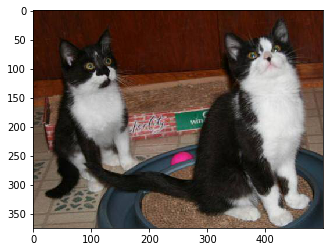

In [24]:
# This is a Python 3.6 format sring which is a convenient way to format a string
# Show the 5th picture
img = plt.imread(f'{PATH}valid/cats/{files[4]}')
plt.imshow(img);

In [25]:
# img is a 3 dimensional array (a.k.a. rank 3 tensor)
print(img.shape)
print(type(img))

(375, 499, 3)
<class 'numpy.ndarray'>


In [26]:
# Show the data of the first 4*4 area of image
img[:4,:4] 

array([[[55, 18,  2],
        [55, 18,  2],
        [55, 18,  2],
        [57, 18,  3]],

       [[55, 18,  2],
        [55, 18,  2],
        [55, 18,  2],
        [57, 18,  3]],

       [[55, 18,  2],
        [55, 18,  2],
        [55, 18,  2],
        [57, 18,  3]],

       [[55, 18,  2],
        [55, 18,  2],
        [55, 18,  2],
        [57, 18,  3]]], dtype=uint8)

## Use a pre-trained RESNET34 model

Here we use a pre-trained resnet34 model to start with, instead of building a model from scratch. This model is trained on ImageNet (1.2 million images and 1000 classes). So we can train our model very quickly(under 20 seconds).

resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks).

In [27]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

The first time to run the code, it will take some time to download the pre-trained model. Besides, there is some time to computes and cash the intermediate information.

In [28]:
arch=resnet34
sz = 224
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learning_rate = 0.005
epoch = 5
learn.fit(learning_rate, epoch)

epoch      trn_loss   val_loss   accuracy                     
    0      0.050186   0.027232   0.9905    
    1      0.047795   0.02631    0.9905                        
    2      0.040551   0.027604   0.99                          
    3      0.036613   0.02716    0.9905                        
    4      0.031736   0.02912    0.989                         



[array([0.02912]), 0.989]

## Analyzing results: looking at pictures

In [29]:
type(data)

fastai.dataset.ImageClassifierData

In [30]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [31]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [32]:
type(data)

fastai.dataset.ImageClassifierData

In [33]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
# ndarray
log_preds.shape

(2000, 2)

The output represents a prediction for cats, and prediction for dogs.
Here we use `argmax()` to give the actual predicted labels of these images.
The index of the max probability in a single tuple is the actual predicted label the model gives.

In [34]:
# Returns the indices of the maximum values along an axis.
# This is actually giving the predicted labels of these images.
preds = np.argmax(log_preds, axis=1)  
# Caculate the probabilities(0, 1) of dogs from log.
probs = np.exp(log_preds[:,1])

In [35]:
# The predicted labels
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [36]:
# The probability of the dogs
probs[:10]

array([0.     , 0.0001 , 0.00152, 0.00113, 0.00001, 0.00002, 0.00003, 0.00003, 0.2108 , 0.09446],
      dtype=float32)

### Images with correct and incorrect labels

In [37]:
# Random select
def rand_by_mask(mask, num): 
    return np.random.choice(np.where(mask)[0], min(len(preds), num), replace=False)
# Select images with right labels
def rand_by_correct(is_correct, num =4): 
    return rand_by_mask((preds == data.val_y)==is_correct, num)

In [38]:
# A simple plots function, which overwrite the plots function in module fastai
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [39]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


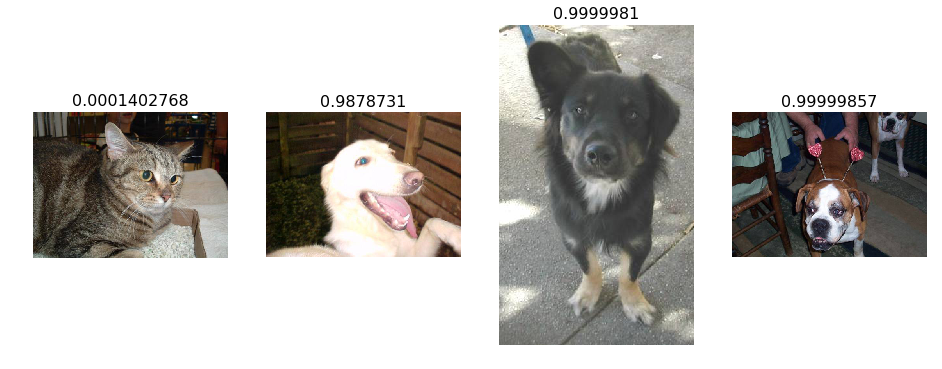

In [40]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True,4), "Correctly classified")

Incorrectly classified
Incorrectly classified
Incorrectly classified


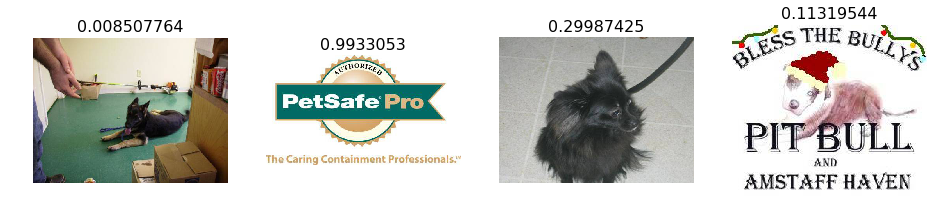

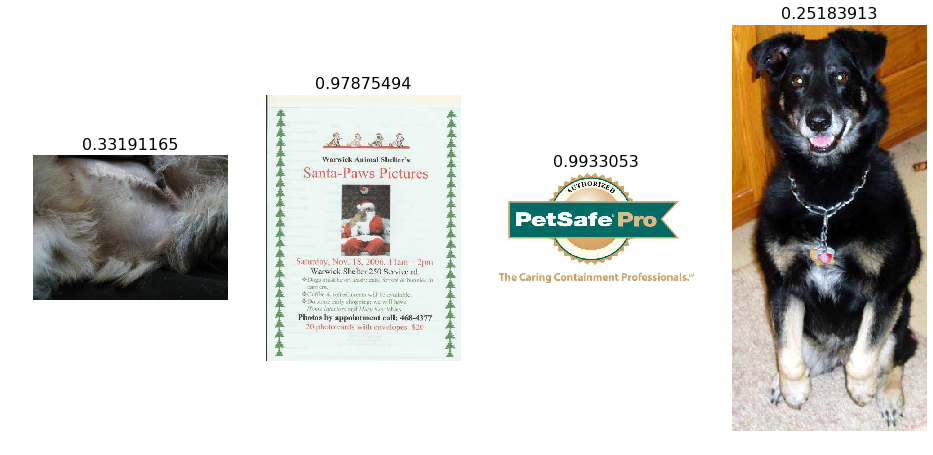

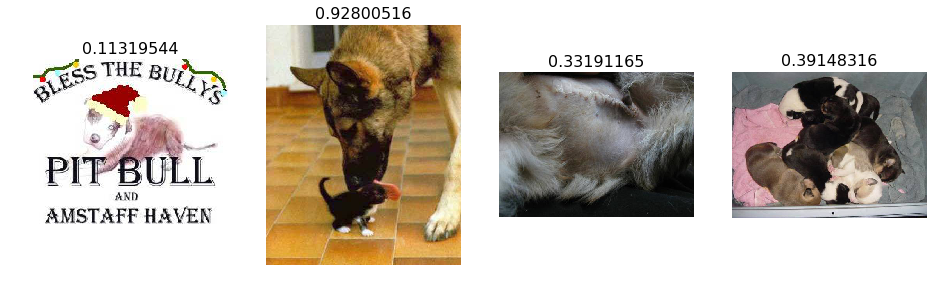

In [41]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False,4), "Incorrectly classified")
plot_val_with_title(rand_by_correct(False,4), "Incorrectly classified")
plot_val_with_title(rand_by_correct(False,4), "Incorrectly classified")

### Most correct and incorrect images 

In [42]:
def most_by_mask(mask, mult, num):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:num]]


def most_by_correct(y, is_correct, num=4): 
    '''
    Use y to determine cat or dog
    '''
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult,num)

Most correct cats


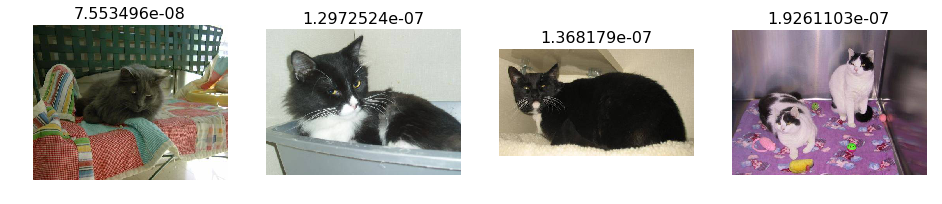

In [43]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


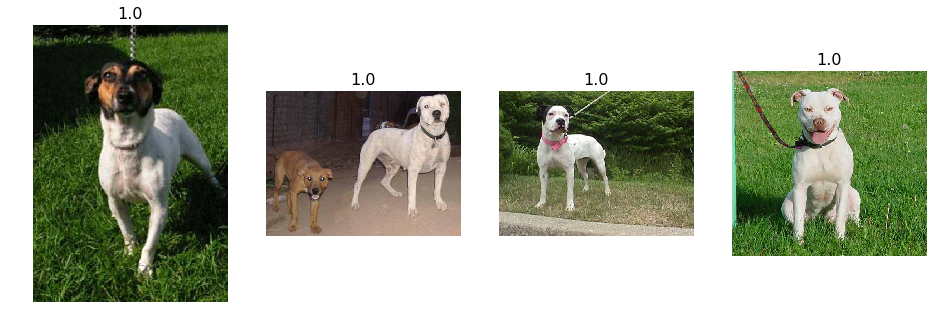

In [44]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


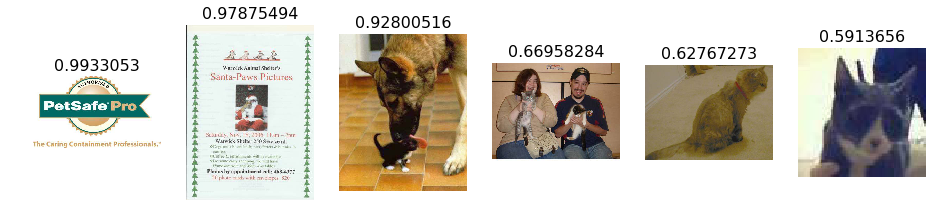

In [45]:
plot_val_with_title(most_by_correct(0, False,6), "Most incorrect cats")

Most incorrect dogs


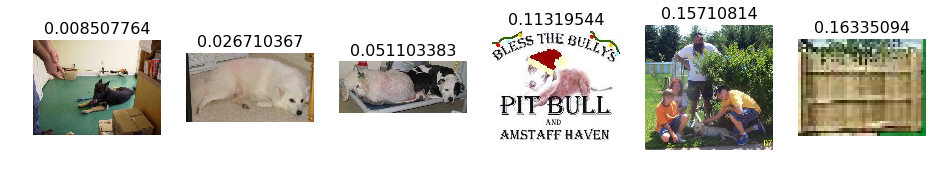

In [46]:
plot_val_with_title(most_by_correct(1, False, 6), "Most incorrect dogs")

## How to choose the learning rate

The method learn.lr_find() helps you find an optimal learning rate. It uses the technique developed in the 2015 paper Cyclical Learning Rates for Training Neural Networks, where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

In [47]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find() 

 75%|███████▌  | 271/360 [00:02<00:01, 75.55it/s, loss=0.117] 


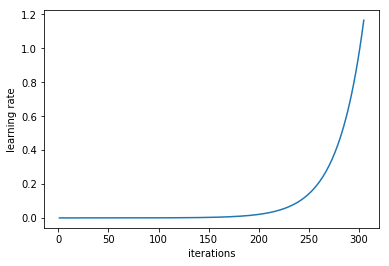

In [48]:
# todo
learn.sched.plot_lr()

Actually, the rate that decreases fastest is at around 1e-3,but we dont use it Instead, we choose 1e-2. The reason is concerned with some other factors below. The short anwser is we will do LR annealing while train our model, so we don't want our LR to be too small initially.

"Why not pick the bottom? The point at which the loss was lowest is where the red circle is. But that learning rate was actually too large at that point and will not likely to converge. So the one
before that would be a better choice (it is always better to pick a learning rate that is smaller than too big)
"

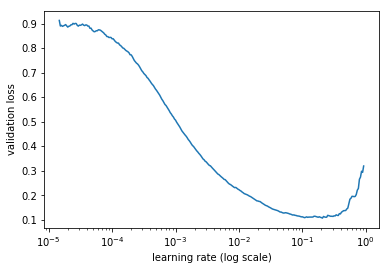

In [49]:
learn.sched.plot()

## Improving model by data augmentation

If you try training for more epochs, you'll notice that we start to overfit, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing aug_tfms (augmentation transforms) to tfms_from_model, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions transforms_side_on. We can also specify random zooming of images up to specified scale by adding the max_zoom parameter.

**Every epoch, we will randomly change the iamge a little bit. In other words, the model is going to see slightly different version of the image each epoch**

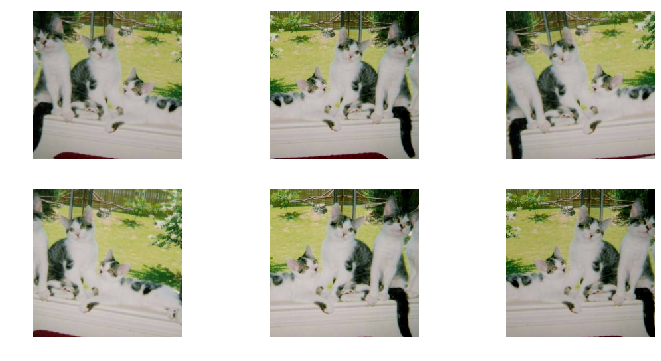

In [59]:
# Decide types of transformation
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    #  Only return the first image in our dataset
    return data.trn_ds.denorm(x)[0]
# Here we randomly change the image 6 times, each time we change a little different
ims = np.stack([get_augs() for i in range(6)])
# Plot the augmentation images
plots(ims, rows=2)

### Create new data including augmentation in the transforms

Here we create the new data object and use it to re-train the model again. Notice: I set the ```precompute = True```. This means that we are telling the learner to precompute the activations from all BUT the last layer in resenet34

In [60]:
# The tfms parameter sets the transformation
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.047936   0.028085   0.991     



[array([0.02808]), 0.991]

## What is precomputed activations and why we need to turn if off when do data augmentation

Precomputed activations are generated based on your data and **the pretrained weights in the hidden layers***. They are the outputs of layers whose weights are frozen. If you set ```precomputed=True``` and you use the same train set to train you model several times, those outputs from frozen layers(usually hidden layers) won’t change. So they can be pre-computed(Don't need to train again) to gain efficiency.

Setting precompute = False and passing the augmented data to the model takes into account the effect of augmentation. Thus activations will be computed from scratch for the new images, but this still would not change the weight of freezen layers. Only change the unfreezen layers(normally the last one, which is fully connected)

If we’re precomputing, we can’t use data augmentation (since the precomputed activations are for some specific input, whereas augmentation changes it every time. Augmentation generates new images every epoch).

**Precompute = True/False** - Precomputed activations that we feed into the network except for the last layer.
**freeze/unfreeze** - weights changes or not during the training(irrespective to the last layer)

## stochastic gradient descent with restarts (SGDR)
This time, we turn off precompute and give the augmentation data.
Besides, we also use SGDR. 
**This time the training will take much longer.**

In [61]:
learn.precompute=False
# cycle_len = 1 indicats using SGDR
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.044932   0.025565   0.9915    
    1      0.04482    0.025745   0.9915                       
    2      0.041289   0.026645   0.989                        



[array([0.02664]), 0.989]

### SGDR and LR annealling 

By adding a parameter, ```cycle_len```, we're using a techinique called stochastic gradient descent with restarts (SGDR), a variant of learning rate annealing, which gradually decreases the learning rate as training progresses, this is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).


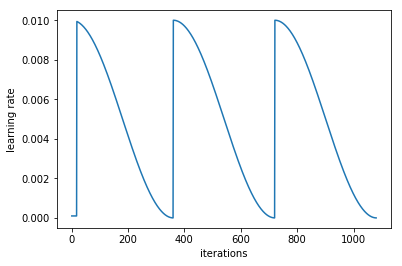

In [63]:
learn.sched.plot_lr()
learn.save('224_lastlayer')
learn.load('224_lastlayer')

## Fine-tuning and differential learning rate annealing

### freeze, unfreeeze, precomputed activations


To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) unfreeze().

Review again:

**Precompute = True/False** - Precomputed activations that we feed into the network except for the last layer.
**freeze/unfreeze** - weights changes or not during the training for all layers bu the last one, which means the last one is always changable

**if we use precompute = True, then freeze / unfreeze do not work as we operate only on already calculated outputs of conv layers.**
**Also data augmentation do not work.**
In order to use data augmentation and fine tune conv layers we need to start with precompute=False. In this case by default all conv layers are freezed. Then we need to unfreeze them.

### differential learning rate
Note that the other layers have already been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as differential learning rates, although there's no standard name for this techique in the literature that we're aware of.

### cyle, epoch, and cycle_mult 

You can use cycle_len to indicates each cycle contains how many epoch. If you give cycle_mult, then each time the number of epoch of each cycle will be multipled to this number. ```cycle = cycle_mult * cycle ```

Intuitively speaking [53:57], if the cycle length(the number of epochs of each cycle) is too short, it starts going down to find a good spot, then pops out, and goes down trying to find a good spot and pops out, and never actually get to find a good one. 

Hence , earlier on, you want it to do that because it is trying to find a spot that is smoother, but later on, you want it to do more exploring. maintain a cycle length for a relatively long time. That is why ```cycle_mult=2``` seems to be a good approach.


In [64]:
# Unfreeze all layers
learn.unfreeze()
# Differential learning rate
lr=np.array([1e-4,1e-3,1e-2])
# 1 epoch + 2 epochs + 4 epochs = 7 epochs
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.045877   0.025775   0.99      
    1      0.035186   0.019682   0.992                        
    2      0.03364    0.021213   0.991                        
    3      0.030401   0.018334   0.993                        
    4      0.021423   0.017532   0.9945                       
    5      0.019521   0.018379   0.9915                       
    6      0.021735   0.017131   0.9925                       



[array([0.01713]), 0.9925]

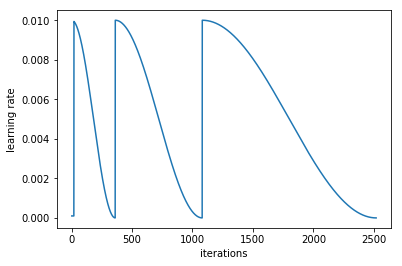

In [65]:
learn.sched.plot_lr()

## The reason why we care about resilency of where we are in the weight space

Short Answer:
We only care about loss in the **validation/test sets**. But our training set can’t see that data. So we need to know whether slightly different datasets might have very different losses.

Imagine a scenario where a model perfectly (over)fits a given training set based on just one pixel intensity, but this solution would be absolutely useless and had not ability to generalize.

The notion that we can tell something about our ability to generalize based on the shape of the surrounding error surface on the train set is supercool and a very useful idea to keep in our mental toolbox. Also, it is interesting to consider this is as a property of various training algorithms, to what extent they not only produce a low train error, but also what measures they take that can help us converge at a nice solution. 

In [66]:
learn.save('224_all')
learn.load('224_all')

## Test Time Augmentation(TTA)

When we do the validation set, all of our inputs to our model must be square. The reason is kind of a minor technical detail, but GPU does not go very quickly if you have different dimensions for different images. This may probably be fixable but for now that is the state of the technology we have.

To make it square, we just pick out the square in the middle — as you can see below, it is understandable why this picture was classified incorrectly:

Most incorrect dogs


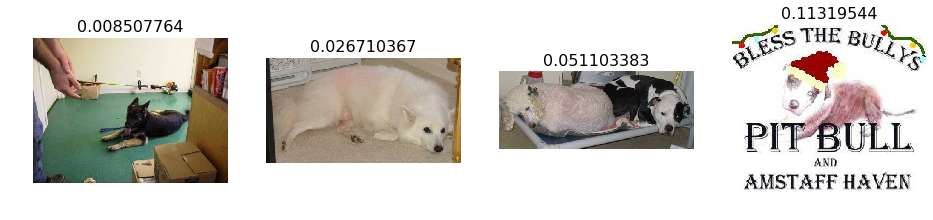

In [67]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

There is something else we can do with data augmentation: use it at inference time (also known as test time). Not surprisingly, this is known as test time augmentation, or just TTA.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's  TTA() method.

In [70]:
log_preds,y = learn.TTA()
# The new probability and label for validation set
probs = np.mean(np.exp(log_preds),0)

(2000, 2)

In [79]:
print(probs)
print(probs.shape)

[[1.      0.     ]
 [0.99999 0.00001]
 [0.99877 0.00123]
 ...
 [0.00013 0.99987]
 [0.00006 0.99994]
 [0.00016 0.99984]]
(2000, 2)


In [72]:
# The new accurancy! Incrediably accurate
accuracy_np(probs, y)

0.9935

## Confusion matrix

A common way to analyze the result of a classification model is to use a confusion matrix. Scikit-learn has a convenient function we can use for this purpose:

[[995   5]
 [  8 992]]


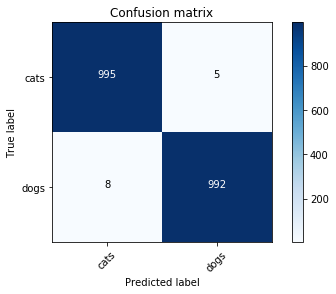

In [80]:
from sklearn.metrics import confusion_matrix
# Preds is the label [0,1]
preds = np.argmax(probs, axis=1)
# The probability of dog label
probs = probs[:,1]
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

### looking at pictures again

Most incorrect cats


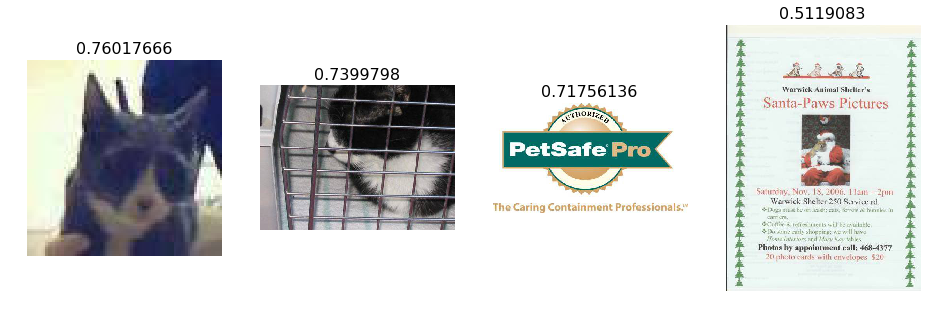

In [83]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


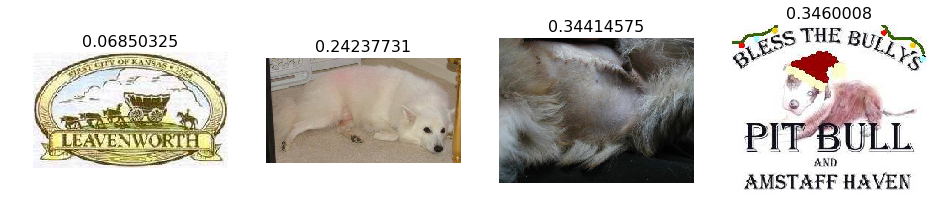

In [84]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and  precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1–2 epochs
4. Train last layer with data augmentation (i.e.  precompute=False ) for 2–3 epochs with  cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer. Rule of thumb: 10x for ImageNet like images, 3x for satellite or medical imaging
7. Use  lr_find()  again (Note: if you call  lr_find  having set differential learning rates, what it prints out is the learning rate of the last layers.)
8. Train full network with  cycle_mult=2  until overfitting
